# Charles Hodgins - LSTM Market Forecasting

Import Libraries


In [ ]:
from dotenv import load_dotenv
import os
import datetime as dt
import requests
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
sns.set_style('whitegrid')
plt.style.use("bmh")
%matplotlib inline


Data API

In [13]:
symbols = ['NVDA', 'AAPL', 'AMZN', 'MSFT']
dataframes = {}
for symbol in symbols:
    if not os.path.exists(f'{symbol}-market-data.csv'):
        stock = yf.Ticker(symbol)
        data = stock.history(period= 'max')
        data.reset_index(inplace=True)
        data.to_csv(f'{symbol}-market-data.csv', index = False, header=True)
        # print(data.head())
        dataframes[symbol] = data
    else:
        dataframes[symbol] = pd.read_csv(f'{symbol}-market-data.csv')

Clean the dataset

In [14]:
def remove_time(date):
    date = dt.datetime.fromisoformat(str(date)).date() if date != dt.datetime.fromisoformat(str(date)).date() else date
    return date
for symbol in symbols:
    dataframes[symbol]['Date'] = dataframes[symbol]['Date'].apply(remove_time)

Resave the dataset to csv after cleaning

In [15]:
for symbol in symbols:
    data.to_csv(f'{symbol}-market-data.csv', index = False, header=True)
    print(f'Stock Market Data for {symbol} to {symbol}-market-data.csv')

Stock Market Data for NVDA to NVDA-market-data.csv
Stock Market Data for AAPL to AAPL-market-data.csv
Stock Market Data for AMZN to AMZN-market-data.csv
Stock Market Data for MSFT to MSFT-market-data.csv


Information about the csv file data

In [16]:
for symbol in symbols:
    dataframes[symbol].info()
    dataframes[symbol].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6719 entries, 0 to 6718
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          6719 non-null   object 
 1   Open          6719 non-null   float64
 2   High          6719 non-null   float64
 3   Low           6719 non-null   float64
 4   Close         6719 non-null   float64
 5   Volume        6719 non-null   int64  
 6   Dividends     6719 non-null   float64
 7   Stock Splits  6719 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 420.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11296 entries, 0 to 11295
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          11296 non-null  object 
 1   Open          11296 non-null  float64
 2   High          11296 non-null  float64
 3   Low           11296 non-null  float64
 4   Close         11296 non-null 

Closing Price Moving Averages

In [17]:
ma = [1,10,20,50]
for _ma in ma:
    for symbol in symbols:
        if _ma != 1:
            dataframes[symbol][f'Ma for {_ma} days'] = dataframes[symbol]['Close'].rolling(_ma).mean()

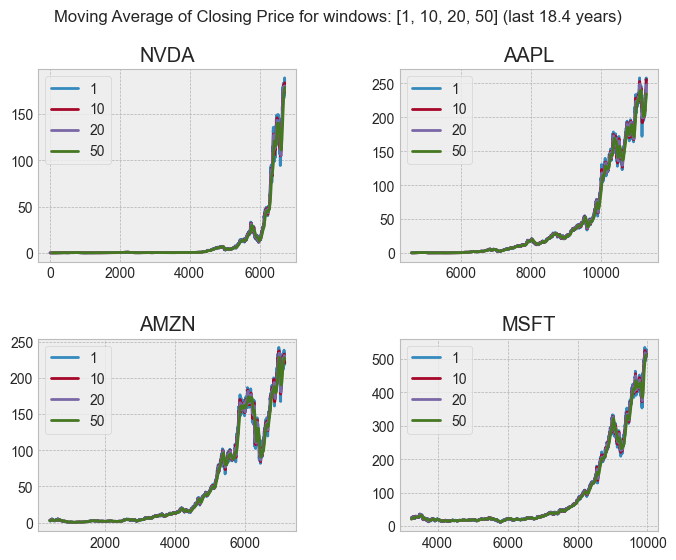

In [ ]:
recent_window = -6719
plt.figure(figsize=(8,6))
plt.suptitle(f'Moving Average of Closing Price for windows: {ma} (last {(recent_window/-365):.1f} years)')
for _ma in ma:
    for i,symbol in enumerate(symbols):
        plt.subplot(2,2,i+1)
        if _ma != 1:
            plt.plot(dataframes[symbol][f'Ma for {_ma} days'].iloc[recent_window:])
        else:
            plt.plot(dataframes[symbol]['Close'].iloc[recent_window:])
        plt.title(symbol)
        plt.subplots_adjust(hspace=0.4, wspace=0.4)
        plt.legend(ma)

plt.show()

Trading Volume over time

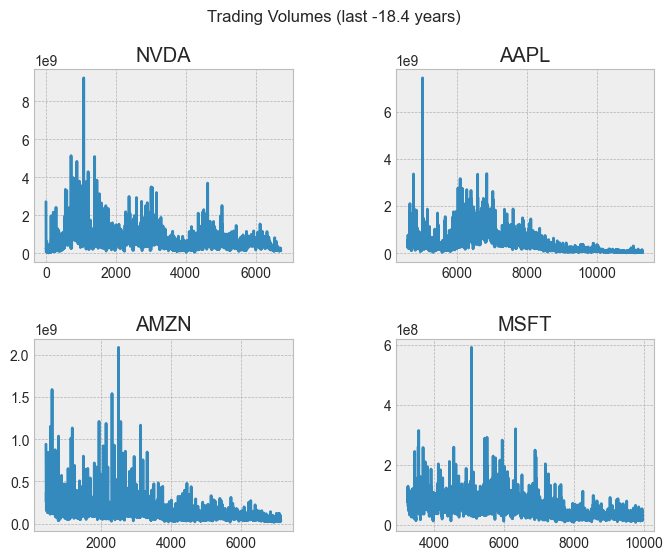

In [64]:
plt.figure(figsize=(8,6))
plt.suptitle(f'Trading Volumes (last {(recent_window/365):.1f} years)')
for i,symbol in enumerate(symbols):
    plt.subplot(2, 2, i+1)
    plt.plot(dataframes[symbol]['Volume'].iloc[recent_window:])
    plt.title(symbol)
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

Average Daily Return

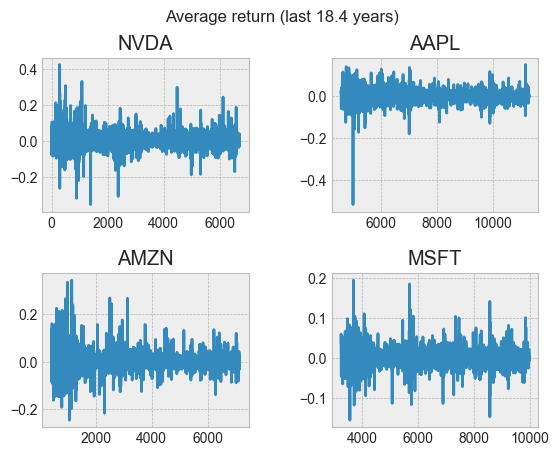

In [78]:
plt.figure()
plt.suptitle(f'Average return (last {(recent_window/-365):.1f} years)')
for i, symbol in enumerate(symbols):
    plt.subplot(2,2,i+1)
    dataframes[symbol]['Daily Return'] = dataframes[symbol]['Close'].iloc[recent_window:].pct_change()
    plt.title(symbol)
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.plot(dataframes[symbol]['Daily Return'])
plt.show()

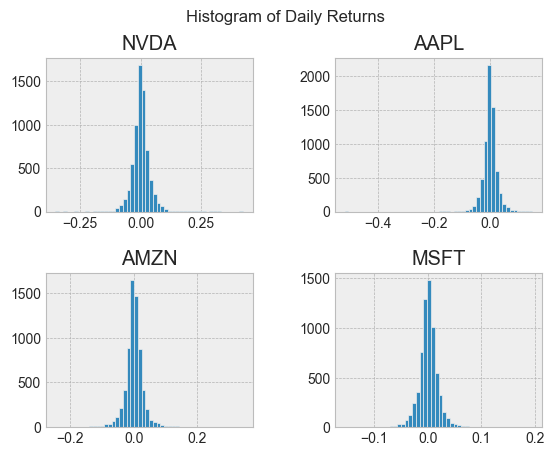

In [68]:
plt.figure()
plt.suptitle(f'Histogram of Daily Returns')
for i, symbol in enumerate(symbols):
    plt.subplot(2,2,i+1)
    plt.title(symbol)
    dataframes[symbol]['Daily Return'].hist(bins=50)
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

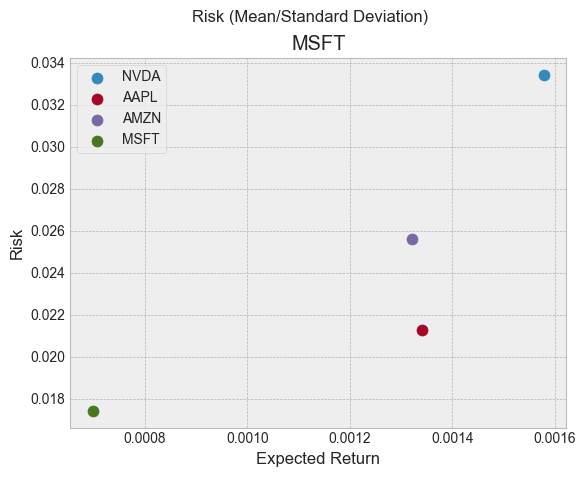

In [ ]:
plt.figure()
plt.suptitle(f'Risk (Mean/Standard Deviation)')
for symbol in symbols:
    rets = dataframes[symbol]['Daily Return'].dropna()
    mean = rets.mean()
    std = rets.std()
    plt.title(symbol)
    plt.scatter(mean,std, s = np.pi*20)
    plt.legend(symbols)
plt.xlabel('Expected Return')
plt.ylabel('Risk')
# plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

Define Training

In [114]:
from sklearn.model_selection import train_test_split
def normalize_z_score(data):
    mean = data.mean()
    std = data.std()
    return (data-mean)/std, mean, std

def create_sequences(data, window_size):
    x, y = [], []
    for i in range(window_size, len(data)):
        x.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

window_size = 60
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

dataset = dataframes['NVDA'].filter(['Close']).values.astype(np.float32)
normalized_dataset, _mean, _std = normalize_z_score(dataset)

total_len = len(normalized_dataset)
train_end = int(total_len*train_ratio)
val_end = int(total_len*(train_ratio+val_ratio))

train_data = normalized_dataset[:train_end]
val_data = normalized_dataset[train_end:val_end]
test_data = normalized_dataset[val_end:]

x_train, y_train = create_sequences(train_data, window_size)

x_val, y_val = create_sequences(val_data, window_size)

x_test, y_test = create_sequences(test_data, window_size)

print(len(x_train), len(x_val), len(x_test))

5315 612 612


In [135]:
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset

class ForecasterLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.LSTM = nn.LSTM(input_size, hidden_size, num_layers,dropout=0.2, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        # input shape - (batch_size, sequence_length, input_size)
        # lstm_out - (batch, sequence, D*H_out)
        lstm_out, (h_n, c_n) = self.LSTM(input) 
        last_hidden_state = lstm_out[:,-1,:] # shape(batch_size, hidden_size)
        out = self.linear(last_hidden_state)
        return out
    
def training_loop(model, optim, criterion, train_loader, val_loader, epochs):
    train_losses = []
    val_losses = []
    train_loss = 0
    val_loss = 0
    model.train()
    for epoch in range(1, epochs+1):
        for x_batch, y_batch in train_loader:
            optim.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optim.step()
            train_loss += loss.item() * x_batch.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        #validation phase
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * x_batch.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        
        if epoch % 5 == 0 or epoch == 1:
                print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")
    return train_losses, val_losses



    
x_train_tensor = torch.from_numpy(x_train).float().reshape((x_train.shape[0], x_train.shape[1], 1))
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
    
x_val_tensor = torch.from_numpy(x_val).float().reshape((x_val.shape[0], x_val.shape[1], 1))
y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(1)

x_test_tensor = torch.from_numpy(x_test).float().reshape((x_test.shape[0], x_test.shape[1], 1))
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for x_batch, y_batch in train_loader:
    print("x_batch shape:", x_batch.shape)
    print("y_batch shape:", y_batch.shape)
    break

x_batch shape: torch.Size([32, 60, 1])
y_batch shape: torch.Size([32, 1])


In [ ]:
model = ForecasterLSTM(1, 64, 3, 1)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0001)
lossfunction = torch.nn.MSELoss()

input_size = 1
hidden_size = 50
num_layers = 2
output_size = 1
window_size = 60
batch_size = 32
num_epochs = 50
learning_rate = 0.001

train_losses, val_losses = training_loop(model, optimizer, lossfunction, train_loader, val_loader, 100)

Epoch 1/100 | Train Loss: 0.045577 | Val Loss: 0.136616
Epoch 5/100 | Train Loss: 0.032331 | Val Loss: 0.160698
Epoch 10/100 | Train Loss: 0.021421 | Val Loss: 0.187310
Epoch 15/100 | Train Loss: 0.014578 | Val Loss: 0.210094
Epoch 20/100 | Train Loss: 0.010289 | Val Loss: 0.229188
Epoch 25/100 | Train Loss: 0.007603 | Val Loss: 0.244948
Epoch 30/100 | Train Loss: 0.005920 | Val Loss: 0.257810
Epoch 35/100 | Train Loss: 0.004865 | Val Loss: 0.268219
Epoch 40/100 | Train Loss: 0.004203 | Val Loss: 0.276588
Epoch 45/100 | Train Loss: 0.003787 | Val Loss: 0.283284
Epoch 50/100 | Train Loss: 0.003525 | Val Loss: 0.288621
Epoch 55/100 | Train Loss: 0.003360 | Val Loss: 0.292862
Epoch 60/100 | Train Loss: 0.003254 | Val Loss: 0.296224
Epoch 65/100 | Train Loss: 0.003187 | Val Loss: 0.298886
Epoch 70/100 | Train Loss: 0.003144 | Val Loss: 0.300989
Epoch 75/100 | Train Loss: 0.003116 | Val Loss: 0.302649
Epoch 80/100 | Train Loss: 0.003097 | Val Loss: 0.303958
Epoch 85/100 | Train Loss: 0.0030

RuntimeError: File 2025-10-07 23:34:34.745105model.pth cannot be opened.

In [137]:
model_path = 'benchmarch_model.pth'
torch.save(model.state_dict(), model_path)

In [ ]:
import random
rand_idx = random.randint(0, len(test_dataset))
sample = x_test_tensor[rand_idx].unsqueeze(0)  # shape: (1, seq_length, 1)
model.eval()
with torch.no_grad():
    pred = model(sample)
print(rand_idx)
print(pred[0])
print(y_test_tensor[rand_idx])

224
tensor([[-0.3340]])
tensor([2.4881])
